In [55]:
import json, os, sys, collections, itertools,random
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, matthews_corrcoef, f1_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.pipeline import Pipeline
from transformers import RobertaForSequenceClassification, RobertaTokenizer
from transformers import Trainer, TrainingArguments
sys.path.append("../src")

In [2]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {
      'accuracy': acc,
    }

# Load data

In [3]:
commands = {
    0:"nothing",
    1:"put",
    2:"remove",
    3:"use",
    4:"unuse",
    5:"check",
    6:"do",
    7:"move",
}
command2idx = {
        "NOOP": 0,
        "PUT": 1,
        "REMOVE": 2,
        "USE": 3,
        "STOP_USING": 4,
        "CHEF_CHECK": 5,
        "CHEF_DO": 6,
        "MOVE_CONTENTS": 7,
    }
with open("../data/ingredients.json", 'r') as f:
    ingredients = dict(json.load(f))
with open("../data/resources.json", 'r') as f:
    resources = json.load(f)
    resources = [(r["id"], r["name"]) for r in resources if 'children' not in r] + [(r["id"], lst["name"]+'/'+r["name"]) for lst in resources if 'children' in lst for r in lst["children"]]
    resources = {k:v for k,v in resources if not k.startswith("VALID_")}
    res2idx = {k:i for i,k in enumerate(resources.keys())}

In [4]:
arg2idx = res2idx
k=len(arg2idx)+1
with open("../data/arg2idx.json", 'r') as f:
    for w, i in json.load(f).items():
        arg2idx[w.replace('-', '_')] = k
        k += 1

In [ ]:
idx2arg = {i:ingredients.get(v,v) for v,i in arg2idx.items()}

# Preprocessing

In [5]:
def triplet_split(s):
    ret = []
    s=s.split()
    for i,t in enumerate(s):
        if i%3==0:
            ret.append([])
        ret[-1].append(t)
    return ret
df = pd.read_csv("seq2seq_4335716.csv")
df["triplet_n"] = df["output_seq"].str.split().str.len()//3
df["triplet_seq"] = df["output_seq"].apply(triplet_split)

df.sample(10)

,input_seq,output_seq,triplet_n,triplet_seq
116,reduce heat .,MOVE_CONTENTS COUNTER1 STOVE_LOW MOVE_CONTENTS...,5,"[[MOVE_CONTENTS, COUNTER1, STOVE_LOW], [MOVE_C..."
125,dot with margarine .,PUT IzrIHcuDJ STOVE_LOW PUT Is_lS1dmt STOVE_LOW,2,"[[PUT, IzrIHcuDJ, STOVE_LOW], [PUT, Is_lS1dmt,..."
220,bake 5 minutes more .,MOVE_CONTENTS COUNTER1 OVEN_MED MOVE_CONTENTS ...,5,"[[MOVE_CONTENTS, COUNTER1, OVEN_MED], [MOVE_CO..."
288,add a dash or two of dry mustard and about 1 t...,PUT IzDRSSnRu COUNTER1 PUT IfztrkJfj COUNTER1,2,"[[PUT, IzDRSSnRu, COUNTER1], [PUT, IfztrkJfj, ..."
233,( soak skewers in water for 1/2 hour before us...,MOVE_CONTENTS REF_CHIL COUNTER1 MOVE_CONTENTS ...,4,"[[MOVE_CONTENTS, REF_CHIL, COUNTER1], [MOVE_CO..."
303,"remove to a paper towel to drain , then crumbl...",MOVE_CONTENTS STOVE_MED COUNTER1 USE TPAPER CO...,3,"[[MOVE_CONTENTS, STOVE_MED, COUNTER1], [USE, T..."
327,season to taste with salt and pepper .,MOVE_CONTENTS COUNTER2 COUNTER1 STOP_USING TBO...,4,"[[MOVE_CONTENTS, COUNTER2, COUNTER1], [STOP_US..."
388,"cook , tightly covered , for 3 hours .",MOVE_CONTENTS COUNTER1 STOVE_LOW USE TPOT STOV...,4,"[[MOVE_CONTENTS, COUNTER1, STOVE_LOW], [USE, T..."
203,add salt and pepper to taste .,STOP_USING TFOIL COUNTER1 PUT IzrIHcuDJ COUNTER1,2,"[[STOP_USING, TFOIL, COUNTER1], [PUT, IzrIHcuD..."
472,bring water to boil .,USE TPAN STOVE_HI PUT IlGA3C7DK STOVE_HI CHEF_...,3,"[[USE, TPAN, STOVE_HI], [PUT, IlGA3C7DK, STOVE..."


<AxesSubplot:ylabel='Frequency'>

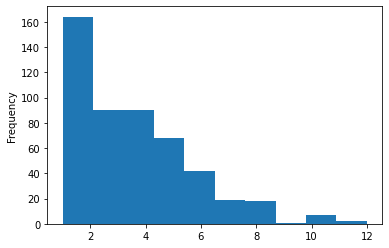

In [6]:
df["triplet_n"].plot.hist()

In [7]:
sentence_idx = list(df.index)
random.shuffle(sentence_idx)
train_idx = sentence_idx[:int(0.8*len(sentence_idx))]

In [74]:
df_prep = df.query("triplet_n<6").explode("triplet_seq")
df_prep.index.name="sentence_index"
df_prep["command"]  =  df_prep["triplet_seq"].apply(lambda x: command2idx[x[0]])
df_prep["arg"]      =  df_prep["triplet_seq"].apply(lambda x: arg2idx[x[1]])
df_prep["resource"] =  df_prep["triplet_seq"].apply(lambda x: res2idx[x[2]])
df_prep=df_prep[["input_seq","triplet_seq",  "command", "arg", "resource"]].reset_index()
df_prep["conditioned_seq"] = df_prep["command"].map(commands) + " <s> " + df_prep["input_seq"]
df_prep["train"]=df_prep["sentence_index"].isin(train_idx)
df_prep

,sentence_index,input_seq,triplet_seq,command,arg,resource,conditioned_seq,train
0,0,brown meat in a big skillet .,"[USE, TSKILLET, STOVE_MED]",3,143,11,use <s> brown meat in a big skillet .,True
1,0,brown meat in a big skillet .,"[PUT, INJApA96N, STOVE_MED]",1,52,11,put <s> brown meat in a big skillet .,True
2,0,brown meat in a big skillet .,"[CHEF_CHECK, LBROWN, STOVE_MED]",5,119,11,check <s> brown meat in a big skillet .,True
3,1,"remove from heat and drain the fat , if any .","[MOVE_CONTENTS, STOVE_MED, FAUCET_OFF]",7,11,21,"move <s> remove from heat and drain the fat , ...",True
4,1,"remove from heat and drain the fat , if any .","[USE, TSKILLET, FAUCET_OFF]",3,143,21,"use <s> remove from heat and drain the fat , i...",True
...,...,...,...,...,...,...,...,...
1223,497,"then cover with hot water , season with walt a...","[CHEF_CHECK, LTIME, STOVE_MED]",5,128,11,"check <s> then cover with hot water , season w...",False
1224,498,add the rice and cook for 15 minutes longer .,"[PUT, IN2e0UIJI, STOVE_MED]",1,51,11,put <s> add the rice and cook for 15 minutes l...,True
1225,498,add the rice and cook for 15 minutes longer .,"[CHEF_CHECK, LTIME, STOVE_MED]",5,128,11,check <s> add the rice and cook for 15 minutes...,True
1226,499,"add the cheese , stir gently and turn off the ...","[PUT, I_qDx9v7e, STOVE_MED]",1,67,11,"put <s> add the cheese , stir gently and turn ...",True


<AxesSubplot:ylabel='Frequency'>

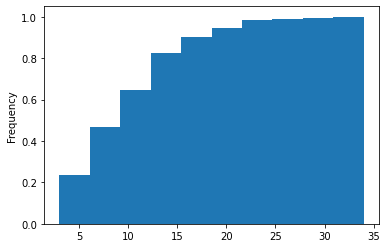

In [9]:
df_prep["input_seq"].str.split().str.len().plot.hist(density=True, cumulative=True)

In [10]:
max_length=20
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

In [11]:
class SingleInstructionDataset(torch.utils.data.Dataset):
    def __init__(self, df, text, train, target, max_length):
        self.encodings = tokenizer(list(df[df["train"]==train][text]), truncation=True, padding=True, max_length=max_length)
        self.labels = list(df[df["train"]==train][target])

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)

# Command Model

In [12]:
# convert our tokenized data into a torch Dataset
command_train_dataset = SingleInstructionDataset(df_prep, "input_seq", True,  "command", max_length)
command_valid_dataset = SingleInstructionDataset(df_prep, "input_seq", False, "command", max_length)

In [13]:
command_names = list(command2idx.keys())
command_model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=len(command_names)).to("cuda")

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

In [13]:
command_training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=30,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=20,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    load_best_model_at_end=True,     # load the best model when finished training (default metric is loss)
    # but you can specify `metric_for_best_model` argument to change to accuracy or other metric
    logging_steps=200,               # log & save weights each logging_steps
    evaluation_strategy="steps",     # evaluate each `logging_steps`
)
command_trainer = Trainer(
    model=command_model,                 # the instantiated Transformers model to be trained
    args=command_training_args,                  # training arguments, defined above
    train_dataset=command_train_dataset,         # training dataset
    eval_dataset=command_valid_dataset,          # evaluation dataset
    compute_metrics=compute_metrics,     # the callback that computes metrics of interest
)
command_trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Runtime,Samples Per Second
200,1.704700,1.705677,0.300380,0.285900,920.041000


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3427, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-42aeac59383a>", line 21, in <module>
    command_trainer.train()
  File "/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/transformers/trainer.py", line 1095, in train
    self.optimizer.step()
  File "/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/torch/optim/lr_scheduler.py", line 65, in wrapper
    return wrapped(*args, **kwargs)
  File "/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/torch/optim/optimizer.py", line 89, in wrapper
    return func(*args, **kwargs)
  File "/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/transformers/optimization.py", line 347, in step
    denom = exp_avg_sq.sqrt().add_(group["eps"])
KeyboardInt

TypeError: object of type 'NoneType' has no len()

In [ ]:
command_model.save_pretrained("command_model")

In [ ]:
def command_prediction(text):
    # prepare our text into tokenized sequence
    inputs = tokenizer(text, padding=True, truncation=True, max_length=max_length, return_tensors="pt").to("cuda")
    # perform inference to our model
    outputs = command_model(**inputs)
    # get output probabilities by doing softmax
    probs = outputs[0].softmax(1)
    # executing argmax function to get the candidate label
    return command_names[probs.argmax()]
command_prediction("brown meat in large skillet")

In [ ]:
command_prediction("add the onion , celery and tomaotes .")

In [ ]:
command_prediction("stir until well mixed .")

In [ ]:
command_prediction("add sugar, lemon and spice")

In [ ]:
tokenizer("<s>")

# Models for arg and resource
## Arg Model

In [14]:
arg_names = list(arg2idx.keys())
arg_model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=len(arg_names)).to("cuda")
arg_train_dataset = SingleInstructionDataset(df_prep, "conditioned_seq", True,  "arg", max_length)
arg_valid_dataset = SingleInstructionDataset(df_prep, "conditioned_seq", False, "arg", max_length)
arg_training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=30,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=20,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    load_best_model_at_end=True,     # load the best model when finished training (default metric is loss)
    # but you can specify `metric_for_best_model` argument to change to accuracy or other metric
    logging_steps=200,               # log & save weights each logging_steps
    evaluation_strategy="steps",     # evaluate each `logging_steps`
    report_to="none"
)
arg_trainer = Trainer(
    model=arg_model,                 # the instantiated Transformers model to be trained
    args=arg_training_args,                  # training arguments, defined above
    train_dataset=arg_train_dataset,         # training dataset
    eval_dataset=arg_valid_dataset,          # evaluation dataset
    compute_metrics=compute_metrics,     # the callback that computes metrics of interest
)
arg_trainer.train()

In [ ]:
arg_model.save_pretrained("arg_model")

## Resource Model

In [13]:
resource_names = list(res2idx.keys())
resource_model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=len(resource_names)).to("cuda")
resource_train_dataset = SingleInstructionDataset(df_prep, "conditioned_seq", True,  "resource", max_length)
resource_valid_dataset = SingleInstructionDataset(df_prep, "conditioned_seq", False, "resource", max_length)
resource_training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=30,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=20,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    load_best_model_at_end=True,     # load the best model when finished training (default metric is loss)
    # but you can specify `metric_for_best_model` argument to change to accuracy or other metric
    logging_steps=200,               # log & save weights each logging_steps
    evaluation_strategy="steps",     # evaluate each `logging_steps`
)
resource_trainer = Trainer(
    model=resource_model,                 # the instantiated Transformers model to be trained
    args=resource_training_args,                  # training arguments, defined above
    train_dataset=resource_train_dataset,         # training dataset
    eval_dataset=resource_valid_dataset,          # evaluation dataset
    compute_metrics=compute_metrics,     # the callback that computes metrics of interest
)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

In [14]:
resource_trainer.train()

Trainer is attempting to log a value of "{0: 'LABEL_0', 1: 'LABEL_1', 2: 'LABEL_2', 3: 'LABEL_3', 4: 'LABEL_4', 5: 'LABEL_5', 6: 'LABEL_6', 7: 'LABEL_7', 8: 'LABEL_8', 9: 'LABEL_9', 10: 'LABEL_10', 11: 'LABEL_11', 12: 'LABEL_12', 13: 'LABEL_13', 14: 'LABEL_14', 15: 'LABEL_15', 16: 'LABEL_16', 17: 'LABEL_17', 18: 'LABEL_18', 19: 'LABEL_19', 20: 'LABEL_20', 21: 'LABEL_21', 22: 'LABEL_22', 23: 'LABEL_23', 24: 'LABEL_24', 25: 'LABEL_25', 26: 'LABEL_26', 27: 'LABEL_27', 28: 'LABEL_28', 29: 'LABEL_29', 30: 'LABEL_30', 31: 'LABEL_31', 32: 'LABEL_32', 33: 'LABEL_33', 34: 'LABEL_34', 35: 'LABEL_35', 36: 'LABEL_36', 37: 'LABEL_37', 38: 'LABEL_38', 39: 'LABEL_39', 40: 'LABEL_40', 41: 'LABEL_41', 42: 'LABEL_42', 43: 'LABEL_43', 44: 'LABEL_44', 45: 'LABEL_45', 46: 'LABEL_46', 47: 'LABEL_47', 48: 'LABEL_48', 49: 'LABEL_49', 50: 'LABEL_50', 51: 'LABEL_51', 52: 'LABEL_52', 53: 'LABEL_53', 54: 'LABEL_54', 55: 'LABEL_55', 56: 'LABEL_56', 57: 'LABEL_57', 58: 'LABEL_58', 59: 'LABEL_59', 60: 'LABEL_60', 61

Step,Training Loss,Validation Loss,Accuracy,Runtime,Samples Per Second
200,3.393200,2.114262,0.416974,0.330600,819.772000
400,1.557200,2.386361,0.450185,0.325500,832.461000
600,0.760100,2.726616,0.453875,0.305100,888.231000
800,0.389100,3.279024,0.435424,0.312400,867.352000
1000,0.206700,3.734532,0.453875,0.312700,866.707000
1200,0.105700,4.082107,0.476015,0.309900,874.492000
1400,0.061500,4.199569,0.464945,0.330100,820.875000
1600,0.045300,4.303107,0.490775,0.328700,824.377000
1800,0.039400,4.337808,0.498155,0.315200,859.728000


TrainOutput(global_step=1800, training_loss=0.7286871165699429, metrics={'train_runtime': 258.4746, 'train_samples_per_second': 6.964, 'total_flos': 429810639033600.0, 'epoch': 30.0, 'init_mem_cpu_alloc_delta': 8127856, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 23615, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 3116877, 'train_mem_gpu_alloc_delta': 2008889856, 'train_mem_cpu_peaked_delta': 154914210, 'train_mem_gpu_peaked_delta': 0})

In [15]:
resource_model.save_pretrained("resource_model")

# Bag of words model for ingredients

In [58]:
X_train = df_prep.query("train")["input_seq"]
X_test = df_prep.query("not train")["input_seq"]
y_train = df_prep.query("train")["arg"]
y_test = df_prep.query("not train")["arg"]

In [59]:
arg_model = Pipeline([
    ("vec", CountVectorizer(min_df=1, max_df=0.7, binary=True)),
    ("model", BernoulliNB()),
])
arg_model.fit(X_train, y_train)
y_pred = arg_model.predict(X_test)
print(accuracy_score(y_test, y_pred))

# Evaluation

In [12]:
resource_names = list(res2idx.keys())
resource_model = RobertaForSequenceClassification.from_pretrained("resource_model", num_labels=len(resource_names)).to("cuda")

In [13]:
command_names = list(command2idx.keys())
command_model = RobertaForSequenceClassification.from_pretrained("command_model", num_labels=len(command_names)).to("cuda")

In [68]:
def prediction(text):
    # COMMAND MODEL
    inputs = tokenizer(text, padding=True, truncation=True, max_length=max_length, return_tensors="pt").to("cuda")
    outputs = command_model(**inputs)
    probs = outputs[0].softmax(1)
    cmd_idx = probs.argmax()
    command = command_names[cmd_idx]
    #RESOURCE MODEL
    text = commands[int(cmd_idx.to('cpu'))] + " </s> " + text
    inputs = tokenizer(text, padding=True, truncation=True, max_length=max_length, return_tensors="pt").to("cuda")
    outputs = resource_model(**inputs)
    probs = outputs[0].softmax(1)
    res_idx = probs.argmax()
    res = resource_names[res_idx]
    arg = idx2arg[arg_model.predict([text])[0]]

    return (command, arg, res)

In [69]:
prediction("brown meat in large skillet")

('USE', 'Skillet', 'STOVE_MED')

In [75]:
df_prep["pred"] = df_prep["input_seq"].apply(prediction)

In [83]:
df_prep

,sentence_index,input_seq,triplet_seq,command,arg,resource,conditioned_seq,train,pred,pred_triplet
0,0,brown meat in a big skillet .,"[USE, TSKILLET, STOVE_MED]",3,143,11,use <s> brown meat in a big skillet .,True,"(PUT, For X minutes, STOVE_MED)","(PUT, LTIME, STOVE_MED)"
1,0,brown meat in a big skillet .,"[PUT, INJApA96N, STOVE_MED]",1,52,11,put <s> brown meat in a big skillet .,True,"(PUT, For X minutes, STOVE_MED)","(PUT, LTIME, STOVE_MED)"
2,0,brown meat in a big skillet .,"[CHEF_CHECK, LBROWN, STOVE_MED]",5,119,11,check <s> brown meat in a big skillet .,True,"(PUT, For X minutes, STOVE_MED)","(PUT, LTIME, STOVE_MED)"
3,1,"remove from heat and drain the fat , if any .","[MOVE_CONTENTS, STOVE_MED, FAUCET_OFF]",7,11,21,"move <s> remove from heat and drain the fat , ...",True,"(STOP_USING, For X minutes, STOVE_MED)","(STOP_USING, LTIME, STOVE_MED)"
4,1,"remove from heat and drain the fat , if any .","[USE, TSKILLET, FAUCET_OFF]",3,143,21,"use <s> remove from heat and drain the fat , i...",True,"(STOP_USING, For X minutes, STOVE_MED)","(STOP_USING, LTIME, STOVE_MED)"
...,...,...,...,...,...,...,...,...,...,...
1223,497,"then cover with hot water , season with walt a...","[CHEF_CHECK, LTIME, STOVE_MED]",5,128,11,"check <s> then cover with hot water , season w...",False,"(PUT, For X minutes, STOVE_MED)","(PUT, LTIME, STOVE_MED)"
1224,498,add the rice and cook for 15 minutes longer .,"[PUT, IN2e0UIJI, STOVE_MED]",1,51,11,put <s> add the rice and cook for 15 minutes l...,True,"(PUT, For X minutes, STOVE_MED)","(PUT, LTIME, STOVE_MED)"
1225,498,add the rice and cook for 15 minutes longer .,"[CHEF_CHECK, LTIME, STOVE_MED]",5,128,11,check <s> add the rice and cook for 15 minutes...,True,"(PUT, For X minutes, STOVE_MED)","(PUT, LTIME, STOVE_MED)"
1226,499,"add the cheese , stir gently and turn off the ...","[PUT, I_qDx9v7e, STOVE_MED]",1,67,11,"put <s> add the cheese , stir gently and turn ...",True,"(CHEF_CHECK, For X minutes, STOVE_MED)","(CHEF_CHECK, LTIME, STOVE_MED)"
